In [17]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../DropEdge/src'))

from collections import defaultdict

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from argparse import Namespace
import tqdm

from sample import Sampler
from models import *
from metric import accuracy, roc_auc_compute_fn

In [2]:
history_path = "../../DropEdge/runs/run_history-dataset_citeseer-type_mutigcn"
history_df = pd.read_csv(history_path)
history_df.head()

,Unnamed: 0,loss_train,acc_train,loss_val,acc_val,cur_lr,s_time,t_time,v_time
0,0,2.043088,0.166115,1.788301,0.158,0.009,0.008908,0.018411,0.054445
1,1,1.992203,0.178808,1.783876,0.158,0.009,0.008620,0.016899,0.015256
2,2,1.977104,0.168874,1.781027,0.158,0.009,0.008281,0.015697,0.014971
3,3,1.960054,0.163355,1.779742,0.158,0.009,0.008127,0.016691,0.014762
4,4,1.927716,0.182671,1.778076,0.224,0.009,0.008350,0.014983,0.014546


Text(0, 0.5, 'accuracy')

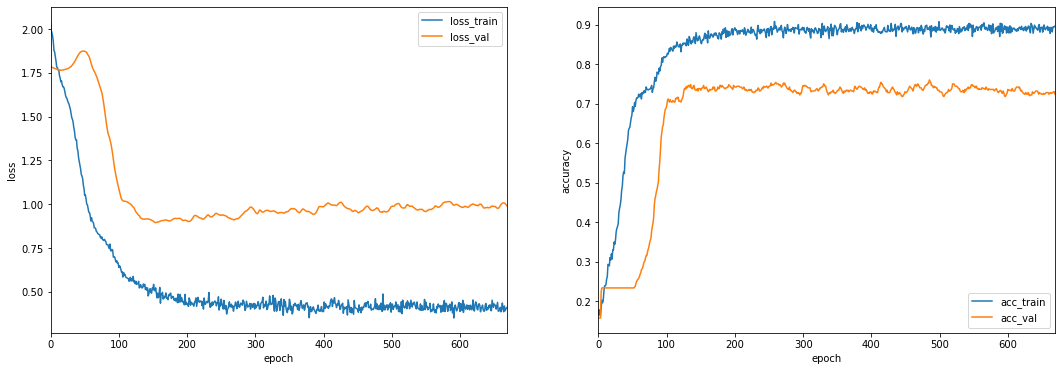

In [3]:
fig,axs = plt.subplots(1, 2, figsize=(18, 6))

history_df[['loss_train', 'loss_val']].plot(ax=axs[0])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

history_df[['acc_train', 'acc_val']].plot(ax=axs[1])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')

In [4]:
model_path = "../../DropEdge/tmpmodel/tmp-0125-170001-LDy.pt"
args_path = "../../DropEdge/tmpmodel/args.json"

with open(args_path, 'r') as f:
    args = json.loads(f.read())
    print("args: ", args)
    args = Namespace(**args)

args.datapath = '../../DropEdge/' + args.datapath
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

sampler = Sampler(args.dataset, args.datapath, args.task_type)
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(args.cuda)
nfeat = sampler.nfeat
nclass = sampler.nclass

base_model = GCNModel(nfeat=nfeat,
                      nhid=args.hidden,
                      nclass=nclass,
                      nhidlayer=args.nhiddenlayer,
                      dropout=args.dropout,
                      baseblock=args.type,
                      inputlayer=args.inputlayer,
                      outputlayer=args.outputlayer,
                      nbaselayer=args.nbaseblocklayer,
                      activation=F.relu,
                      withbn=args.withbn,
                      withloop=args.withloop,
                      aggrmethod=args.aggrmethod,
                      mixmode=args.mixmode)

if device == torch.device('cuda'):
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    
base_model.load_state_dict(state_dict)
base_model.to(device)

args:  {'no_cuda': False, 'fastmode': False, 'seed': 42, 'epochs': 1000, 'lr': 0.009, 'lradjust': False, 'weight_decay': 0.001, 'mixmode': False, 'warm_start': '', 'debug': True, 'dataset': 'citeseer', 'datapath': 'data//', 'early_stopping': 400, 'no_tensorboard': False, 'type': 'mutigcn', 'inputlayer': 'gcn', 'outputlayer': 'gcn', 'hidden': 256, 'dropout': 0.8, 'withbn': True, 'withloop': True, 'nhiddenlayer': 1, 'normalization': 'BingGeNormAdj', 'sampling_percent': 0.05, 'nbaseblocklayer': 3, 'aggrmethod': 'nores', 'task_type': 'full', 'cuda': True}
Load full supervised task.


/home/ms/Learning/DropEdge/src/normalization.py:110: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


GCNModel(
  (ingc): GraphConvolutionBS(
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outgc): GraphConvolutionBS(
    (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (midlayer): ModuleList(
    (0): MultiLayerGCNBlock(
      (model): GraphBaseBlock(
        (hiddenlayers): ModuleList(
          (0): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
    )
  )
)

In [5]:
class GraphConvolutionBSSVD(Module):
    def __init__(self, orig_layer, r):
        super(GraphConvolutionBSSVD, self).__init__()
        self.r = r
        
        self.in_features = orig_layer.in_features
        self.out_features = orig_layer.out_features
        self.sigma = orig_layer.sigma
        
        U, s, V = torch.svd(orig_layer.weight)
        
        self.U = nn.Parameter(U[:, :r])
        self.s = nn.Parameter(s[:r])
        self.Vt = nn.Parameter(V.T[:r, :])
        
        if orig_layer.bias is not None:
            self.bias = Parameter(orig_layer.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, input, adj):
        support = torch.mm(input, self.U)
        support = support * self.s
        support = torch.mm(support, self.Vt)
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            output = output + self.bias
        
        return self.sigma(output)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) \
               + ', ' + str(self.r) + ')'

In [6]:
def test(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args.normalization,
    cuda= device == torch.device('cuda')
)

In [7]:
import copy

def make_new_model(model, r):
    new_model = copy.deepcopy(model)
    new_model.ingc = GraphConvolutionBSSVD(new_model.ingc, r)
    new_model.to(device)
    return new_model

In [19]:
base_loss_test, base_acc_test = test(base_model, test_adj, test_fea)
print(f"Loss test on base_model = {base_loss_test}\nAcc test of base_model = {base_acc_test}")

Loss test on base_model = 0.7389928698539734
Acc test of base_model = 0.784


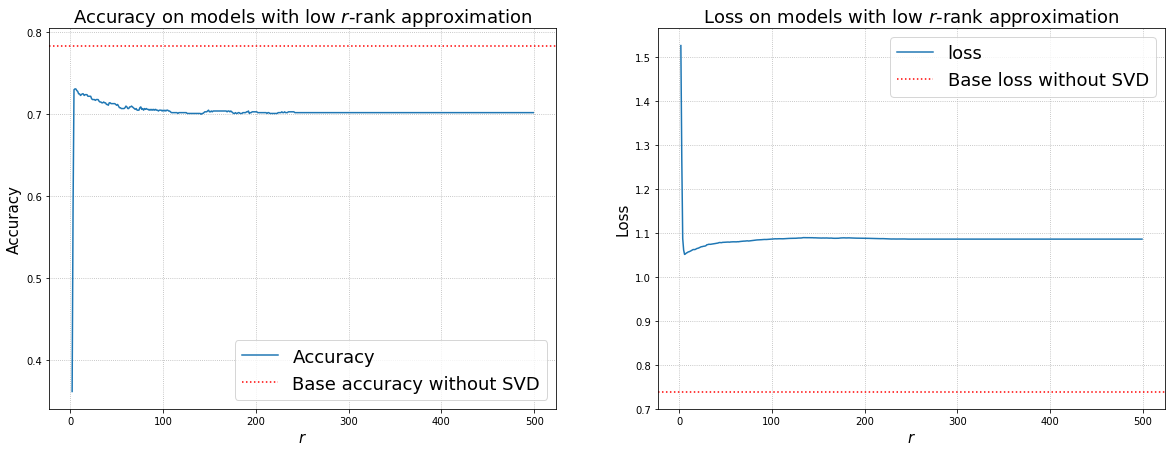

In [27]:
experiments = {
    'r': [],
    'loss': [],
    'acc': []
}

for r in tqdm.notebook.tqdm(range(2, 500)):
    model = make_new_model(base_model, r)
    loss_test, acc_test = test(model, test_adj, test_fea)
    experiments['r'].append(r)
    experiments['loss'].append(loss_test)
    experiments['acc'].append(acc_test)
    del model
    
fig,axs = plt.subplots(1, 2)
fig.set_size_inches(20, 7)

axs[0].plot(experiments['r'], experiments['acc'], label='Accuracy')
axs[0].axhline(y=base_acc_test, color='r', linestyle=':', label="Base accuracy without SVD")
axs[0].legend(fontsize=18)
axs[0].set_title("Accuracy on models with low $r$-rank approximation", fontsize=18)
axs[0].set_ylabel("Accuracy", fontsize=15)
axs[0].set_xlabel("$r$", fontsize=15)
axs[0].grid(ls=":")

axs[1].plot(experiments['r'], experiments['loss'], label='loss')
axs[1].axhline(y=base_loss_test, color='r', linestyle=':', label="Base loss without SVD")
axs[1].legend(fontsize=18)
axs[1].set_title("Loss on models with low $r$-rank approximation", fontsize=18)
axs[1].set_ylabel("Loss", fontsize=15)
axs[1].set_xlabel("$r$", fontsize=15)
axs[1].grid(ls=":")